# IMPORTS

In [1018]:
#Importing the Libraries

import pandas as pd
import numpy as np
import datetime
from datetime import date,timedelta
from dateutil.relativedelta import relativedelta

from nsepy import get_history
import yfinance as yf
import plotly.express as px 

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score,make_scorer
import matplotlib.dates as mandates
from sklearn import linear_model

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import xgboost as xg

from sklearn.ensemble import RandomForestRegressor

from fbprophet import Prophet


import talib
import math


import warnings
warnings.filterwarnings("ignore")
 
from tsai.models.MINIROCKET import MiniRocketVotingRegressor

from sktime.datatypes._panel._convert import from_2d_array_to_nested


import logging
logging.getLogger("urllib3").setLevel(logging.ERROR)
logging.getLogger("fbprophet").setLevel(logging.WARNING)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Initialize

In [1019]:
date.today()

datetime.date(2023, 5, 28)

In [1020]:
# Data extracted for range of days. Last N days of data used as test data and remaining as train data.
DATA_RANGE_DAYS = 365*5
DATA_TEST_DAYS = 5

#STOCK = 'HINDUNILVR'
TARGET_COLUMN = 'Close'

PREV_CLOSE_COL_NAME='Prev Close'
CLOSE_COL_NAME='Close'

# Get the dates in datetime format for extracting the details

END_DATE = date.today() 
START_DATE = END_DATE - timedelta(DATA_RANGE_DAYS)
#TRAIN_END_DATE = END_DATE - timedelta(DATA_TEST_DAYS-1)
#TEST_START_DATE = END_DATE - timedelta(DATA_TEST_DAYS)
print(f'Data:{START_DATE} to {END_DATE}')

# Variables for derived features
RSI_PERIOD = 14


MACD_FAST_EMA = 12
MACD_SLOW_EMA = 26
MACD_SIGNAL_PERIOD = 9 

ROC_TIMEPERIOD = 10


MAX_ROWS_TO_DERIVE_FEATURES = 200

RANDOM_STATE = 123

COL_TO_DERIVE_FEATURES = PREV_CLOSE_COL_NAME


minmax_scaler = MinMaxScaler()

Data:2018-05-29 to 2023-05-28


# Fetch data

In [1021]:
def get_stock_data(scrip, start_date=START_DATE, end_date=END_DATE, is_index=False):
    return get_history(symbol=scrip, start=start_date, end=end_date,index = is_index)


def add_prev_close_column(input_df):
    input_df[PREV_CLOSE_COL_NAME]=input_df[CLOSE_COL_NAME].shift(1)
    
def get_crypto_data(ticker, time_period="5y"):
    df = yf.Ticker(ticker).history(period=time_period)
    df.drop(['Volume','Dividends','Stock Splits'], inplace=True,axis=1)
    
    if PREV_CLOSE_COL_NAME not in df.columns:
        add_prev_close_column(df)
    return df




In [1022]:
scrip="BTC-USD"
time_period="6y"
stock_full_df=get_crypto_data(scrip, time_period)
display(stock_full_df.head(3))
stock_full_df.tail(3)

,Open,High,Low,Close,Prev Close
Date,,,,,
2017-05-28,2054.080078,2267.340088,2054.080078,2155.800049,NaN
2017-05-29,2159.429932,2307.050049,2107.169922,2255.610107,2155.800049
2017-05-30,2255.360107,2301.959961,2124.570068,2175.469971,2255.610107


,Open,High,Low,Close,Prev Close
Date,,,,,
2023-05-26,26474.181641,26916.669922,26343.949219,26719.291016,26476.207031
2023-05-27,26720.181641,26888.882812,26621.140625,26868.353516,26719.291016
2023-05-28,26861.359375,27288.478516,26805.046875,27265.568359,26868.353516


# Utility methods

# Data treatment

## Check for infinity values

In [1023]:
def print_inf_values(input_df):
    infinity_count = np.isinf(input_df.isin([np.inf, -np.inf])).values.sum()
    print(f'No. of infinity values in the dataset:{infinity_count}')


In [1024]:

print_inf_values(stock_full_df)

No. of infinity values in the dataset:0


## Check for missing values

In [1025]:
# Check for missing values in the dataframe and print them
def print_missing_columns(input_df):
    # Print missing percentage of only columns with missing values
    missing_columns = input_df.columns[input_df.isnull().any()]
    if not missing_columns.empty:
        missing_count = input_df[missing_columns].isnull().sum()
        missing_col_type = pd.Series([type(col) for col in input_df[missing_columns]],index = missing_columns) 
        unique_count = input_df[missing_columns].nunique()

        missing_df = pd.concat({
                        "Missing": missing_count, 
                        "Missing %": missing_count/len(input_df.index)*100,
                        "Type": missing_col_type,
                        "Unique Count": unique_count
                       } , 
                       axis = 1).sort_values(by = 'Missing', ascending = False)

        display(missing_df)
    else:
        display("NO MISSING VALUES IN THE DATAFRAME")

In [1026]:
print_missing_columns(stock_full_df)

,Missing,Missing %,Type,Unique Count
Prev Close,1,0.04562,<class 'str'>,2190


Previous close of the first row is expected to be empty

# Add features to the data

## Simple Moving Average

In [1027]:
def apply_sma(df, col):
    df['20_sma'] = df[col].rolling(window=20).mean()
    df['50_sma'] = df[col].rolling(window=50).mean()
    df['200_sma'] = df[col].rolling(window=200).mean()
    return df

## EMA

In [1028]:
def apply_ema(df, col):
    df['20_ema'] = talib.EMA(df[col], timeperiod=20)
    df['50_ema'] = talib.EMA(df[col], timeperiod=50)
    df['200_ema'] = talib.EMA(df[col], timeperiod=200)
    return df


## RSI

In [1029]:

def apply_rsi(df, col):
    df['rsi'] = talib.RSI(df[col], RSI_PERIOD) 
    return df


## MACD

In [1030]:

def apply_macd(df, col):
    df['macd'], df['signal'], df['hist'] = talib.MACD(df[col], 
                                fastperiod=MACD_FAST_EMA, slowperiod=MACD_SLOW_EMA, signalperiod=MACD_SIGNAL_PERIOD)

    return df

## BOLLINGER BAND

In [1031]:

def apply_bollinger_band(df, col):
    # 20-day moving average 
    df['sma_bb'] = df[col].rolling(window=20).mean()

    # upper and lower bollinger bands: SMA +/- 2 * standard deviation
    df['stddev'] = df[col].rolling(window=20).std()
    df['upper_bb'] = df['sma_bb'] + (2 * df['stddev'])
    df['lower_bb'] = df['sma_bb'] - (2 * df['stddev'])

    return df


## ROC - RATE OF CHANGE

In [1032]:
def apply_roc(df, col):
    # ROC
    df['roc'] = talib.ROC(df[col], timeperiod = ROC_TIMEPERIOD)

    return df

## PPO - Percentage Price Oscillator

In [1033]:
def apply_ppo(df, col):
    # PPO
    df['ppo'] = talib.PPO(df[col])

    return df

## Hilbert Transform - Trend vs Cycle Mode

In [1034]:
def apply_trendmode(df, col):
    # HT_TRENDMODE
    df['ht_trend'] = talib.HT_TRENDMODE(df[col])

    return df

## Hilbert Transform - Dominant Cycle Phase


In [1035]:
def apply_domcycphase(df, col):
    # HT_DCPHASE
    df['ht_dcphase'] = talib.HT_DCPHASE(df[col])

    return df

## SUPERTREND

In [1036]:
# Supertrend
def tr(data):
    data['previous_close'] = data['Close'].shift(1)
    data['high-low'] = abs(data['High'] - data['Low'])
    data['high-pc'] = abs(data['High'] - data['previous_close'])
    data['low-pc'] = abs(data['Low'] - data['previous_close'])

    tr = data[['high-low', 'high-pc', 'low-pc']].max(axis=1)

    return tr

def atr(data, period):
    data['tr'] = tr(data)
    atr = data['tr'].rolling(period).mean()

    return atr

def supertrend(df, period=7, atr_multiplier=3):
    hl2 = (df['High'] + df['Low']) / 2
    df['atr'] = atr(df, period)
    df['upperband'] = hl2 + (atr_multiplier * df['atr'])
    df['lowerband'] = hl2 - (atr_multiplier * df['atr'])
    df['in_uptrend'] = True

    for current in range(1, len(df.index)):
        previous = current - 1

        if df['Close'][current] > df['upperband'][previous]:
            df['in_uptrend'][current] = True
        elif df['Close'][current] < df['lowerband'][previous]:
            df['in_uptrend'][current] = False
        else:
            df['in_uptrend'][current] = df['in_uptrend'][previous]

            if df['in_uptrend'][current] and df['lowerband'][current] < df['lowerband'][previous]:
                df['lowerband'][current] = df['lowerband'][previous]

            if not df['in_uptrend'][current] and df['upperband'][current] > df['upperband'][previous]:
                df['upperband'][current] = df['upperband'][previous]
        
    return df


## CANDLESTICK PATTERNS

In [1037]:
def apply_doji(df):
    df['doji'] = talib.CDLDOJI(df['Open'], df['High'], df['Low'], df['Close'])
    return df

NOTE: Can add more candlestick patterns here if required

## Create the derived features

In [1038]:
def create_derived_features(df):
    input_col = COL_TO_DERIVE_FEATURES
    input_df = df.copy()
    input_df = apply_sma(input_df, input_col)
    input_df = apply_ema(input_df, input_col)
    input_df = apply_rsi(input_df, input_col)
    input_df = apply_macd(input_df, input_col)
    input_df = apply_bollinger_band(input_df, input_col)
    input_df = apply_roc(input_df, input_col)
    input_df = apply_ppo(input_df, input_col)
    input_df = apply_trendmode(input_df, input_col)
    input_df = apply_domcycphase(input_df, input_col)
    
    input_df = apply_domcycphase(input_df, input_col)
    

    
    #input_df = supertrend(input_df) # Needs high and low as well 
    #input_df = apply_doji(input_df)# Needs high and low as well 
    return input_df

In [1039]:
stock_derived_complete_df = create_derived_features(stock_full_df)

In [1040]:
display(stock_derived_complete_df.head(2))
display(stock_derived_complete_df.tail(2))

,Open,High,Low,Close,Prev Close,20_sma,50_sma,200_sma,20_ema,50_ema,...,signal,hist,sma_bb,stddev,upper_bb,lower_bb,roc,ppo,ht_trend,ht_dcphase
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-28,2054.080078,2267.340088,2054.080078,2155.800049,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2017-05-29,2159.429932,2307.050049,2107.169922,2255.610107,2155.800049,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


,Open,High,Low,Close,Prev Close,20_sma,50_sma,200_sma,20_ema,50_ema,...,signal,hist,sma_bb,stddev,upper_bb,lower_bb,roc,ppo,ht_trend,ht_dcphase
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-27,26720.181641,26888.882812,26621.140625,26868.353516,26719.291016,27089.574805,28235.861719,22740.777227,27175.184655,27425.016099,...,-404.153062,-16.898148,27089.574805,488.411200,28066.397205,26112.752405,-1.173812,-2.149707,1,53.389331
2023-05-28,26861.359375,27288.478516,26805.046875,27265.568359,26868.353516,27010.243555,28214.711602,22782.412637,27145.962642,27403.186194,...,-401.950732,8.809320,27010.243555,369.288585,27748.820725,26271.666384,-1.936031,-2.080459,1,44.878715


**After adding the derived features for the moving averages, consider the data of last 5 years for further model training**

In [1041]:

start_date_5yrs = date.today() - relativedelta(years=5)
# Consider last 5y data
stock_derived_df = stock_derived_complete_df[stock_derived_complete_df.index > pd.to_datetime(start_date_5yrs)]
stock_derived_df.shape

(1826, 23)

In [1042]:
stock_derived_df.to_csv("derived_df.csv")

In [1043]:
display(stock_derived_df.head(2))
display(stock_derived_df.tail(2))

,Open,High,Low,Close,Prev Close,20_sma,50_sma,200_sma,20_ema,50_ema,...,signal,hist,sma_bb,stddev,upper_bb,lower_bb,roc,ppo,ht_trend,ht_dcphase
Date,,,,,,,,,,,,,,,,,,,,,
2018-05-29,7129.459961,7526.419922,7090.680176,7472.589844,7135.990234,8184.365991,8499.903389,10378.231008,8051.954569,8416.230422,...,-268.526111,-131.285649,8184.365991,599.150435,9382.666862,6986.065121,-13.513315,-7.897597,1,3.559815
2018-05-30,7469.729980,7573.770020,7313.600098,7406.520020,7472.589844,8091.736499,8513.940586,10382.503257,7996.776976,8379.224909,...,-293.678208,-100.608387,8091.736499,555.082193,9201.900885,6981.572113,-9.392179,-7.557471,1,-0.000760


,Open,High,Low,Close,Prev Close,20_sma,50_sma,200_sma,20_ema,50_ema,...,signal,hist,sma_bb,stddev,upper_bb,lower_bb,roc,ppo,ht_trend,ht_dcphase
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-27,26720.181641,26888.882812,26621.140625,26868.353516,26719.291016,27089.574805,28235.861719,22740.777227,27175.184655,27425.016099,...,-404.153062,-16.898148,27089.574805,488.411200,28066.397205,26112.752405,-1.173812,-2.149707,1,53.389331
2023-05-28,26861.359375,27288.478516,26805.046875,27265.568359,26868.353516,27010.243555,28214.711602,22782.412637,27145.962642,27403.186194,...,-401.950732,8.809320,27010.243555,369.288585,27748.820725,26271.666384,-1.936031,-2.080459,1,44.878715


# Drop rows with NaN

In [1045]:
stock_derived_df.isna().sum().sum()

0

In [1046]:
# # Most models cannot handle NaN in the data. Drop the NaNs in the newly created columns (MA columns)
print(f'Shape before dropping NaN values:{stock_derived_df.shape}')
#stock_derived_df.dropna(inplace=True)
#print(f'Shape after dropping NaN values:{stock_derived_df.shape}')

Shape before dropping NaN values:(1826, 23)


In [1047]:
stock_derived_df[stock_derived_df.isnull().any(axis=1)]

,Open,High,Low,Close,Prev Close,20_sma,50_sma,200_sma,20_ema,50_ema,...,signal,hist,sma_bb,stddev,upper_bb,lower_bb,roc,ppo,ht_trend,ht_dcphase
Date,,,,,,,,,,,,,,,,,,,,,


In [1048]:
stock_derived_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Prev Close', '20_sma', '50_sma',
       '200_sma', '20_ema', '50_ema', '200_ema', 'rsi', 'macd', 'signal',
       'hist', 'sma_bb', 'stddev', 'upper_bb', 'lower_bb', 'roc', 'ppo',
       'ht_trend', 'ht_dcphase'],
      dtype='object')

In [1049]:
## Drop the columns that are not required to train the model
COLS_TO_DROP=['Open', 'High', 'Low', 'Prev Close']
stock_derived_df=stock_derived_df.drop(COLS_TO_DROP,axis=1)

In [1050]:
stock_derived_df.shape

(1826, 19)

# EDA

## Close price distribution

<AxesSubplot:xlabel='Close', ylabel='Density'>

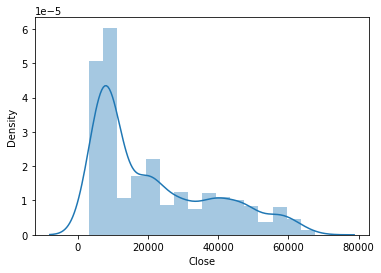

In [1051]:
sns.distplot(stock_derived_df[TARGET_COLUMN])

# Check for multicollinearity

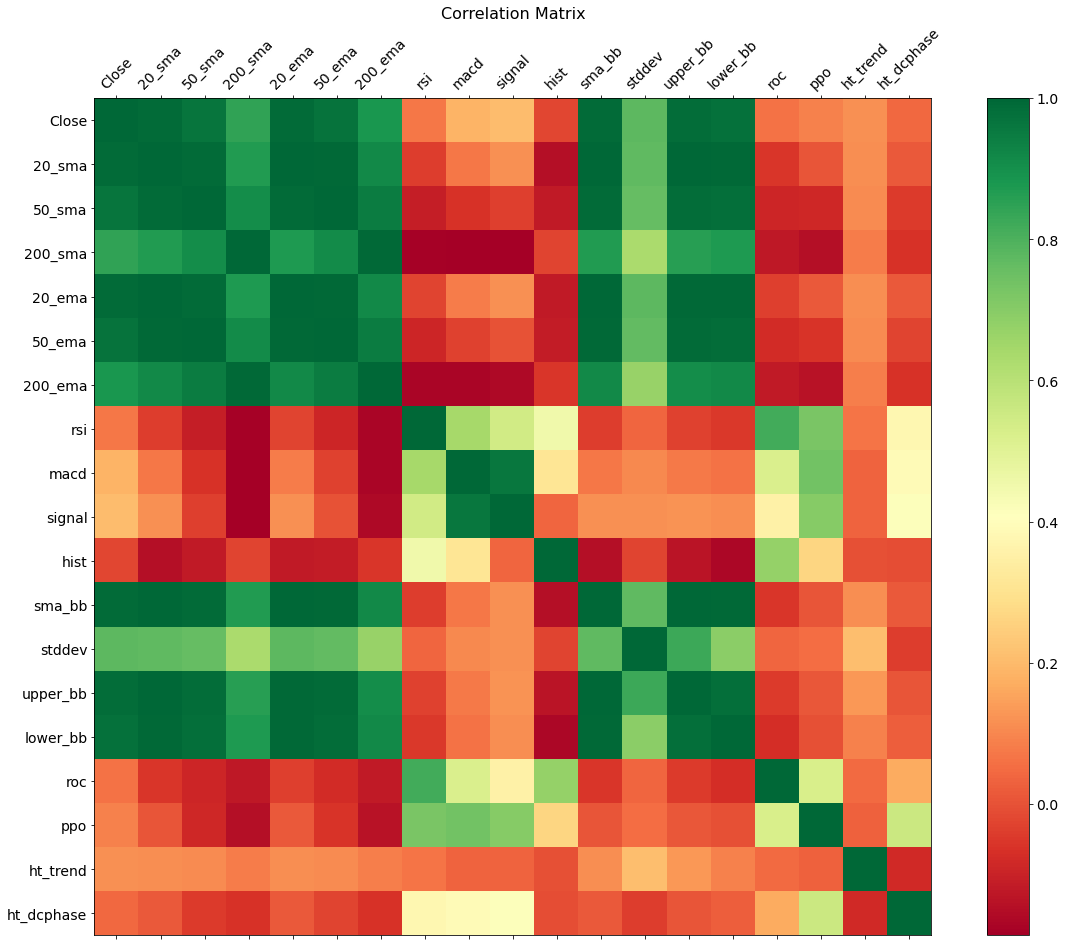

In [1052]:
def plot_correlation(df):
    f = plt.figure(figsize=(20, 15))

    ax = plt.matshow(corr, fignum=f.number,cmap='RdYlGn')
    plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
    plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    #ax.set_ylim([0,2])
    plt.title('Correlation Matrix', fontsize=16);
    
corr=stock_derived_df.corr()
plot_correlation(stock_derived_df)


In [1053]:
corr.style.background_gradient(cmap='coolwarm').set_precision(1)

,Close,20_sma,50_sma,200_sma,20_ema,50_ema,200_ema,rsi,macd,signal,hist,sma_bb,stddev,upper_bb,lower_bb,roc,ppo,ht_trend,ht_dcphase
Close,1.0,1.0,1.0,0.8,1.0,1.0,0.9,0.1,0.2,0.2,-0.0,1.0,0.8,1.0,1.0,0.1,0.1,0.1,0.0
20_sma,1.0,1.0,1.0,0.9,1.0,1.0,0.9,-0.0,0.1,0.1,-0.1,1.0,0.8,1.0,1.0,-0.1,0.0,0.1,0.0
50_sma,1.0,1.0,1.0,0.9,1.0,1.0,0.9,-0.1,-0.1,-0.0,-0.1,1.0,0.8,1.0,1.0,-0.1,-0.1,0.1,-0.0
200_sma,0.8,0.9,0.9,1.0,0.9,0.9,1.0,-0.2,-0.2,-0.2,-0.0,0.9,0.6,0.9,0.9,-0.1,-0.1,0.1,-0.1
20_ema,1.0,1.0,1.0,0.9,1.0,1.0,0.9,-0.0,0.1,0.1,-0.1,1.0,0.8,1.0,1.0,-0.0,0.0,0.1,0.0
50_ema,1.0,1.0,1.0,0.9,1.0,1.0,0.9,-0.1,-0.0,0.0,-0.1,1.0,0.8,1.0,1.0,-0.1,-0.1,0.1,-0.0
200_ema,0.9,0.9,0.9,1.0,0.9,0.9,1.0,-0.2,-0.2,-0.2,-0.1,0.9,0.7,0.9,0.9,-0.1,-0.1,0.1,-0.1
rsi,0.1,-0.0,-0.1,-0.2,-0.0,-0.1,-0.2,1.0,0.6,0.5,0.5,-0.0,0.0,-0.0,-0.1,0.8,0.7,0.1,0.4
macd,0.2,0.1,-0.1,-0.2,0.1,-0.0,-0.2,0.6,1.0,1.0,0.3,0.1,0.1,0.1,0.1,0.5,0.7,0.0,0.4
signal,0.2,0.1,-0.0,-0.2,0.1,0.0,-0.2,0.5,1.0,1.0,0.0,0.1,0.1,0.1,0.1,0.4,0.7,0.0,0.4


# Train/Test split

In [1054]:
def split_data(data_df,target):
    train = data_df.iloc[0:-DATA_TEST_DAYS]
    test = data_df.iloc[-DATA_TEST_DAYS:]
    train_X = train.drop(target, axis=1)
    train_y = train[target]
    test_X = test.drop(target, axis=1)
    test_y = test[target]
    return train_X, train_y, test_X, test_y

# Scale the data

In [1057]:
#Scale the features
def fit_transform_scaler(df_X):
    global minmax_scaler
    df_X_transformed = minmax_scaler.fit_transform(df_X)
    df_X_scaled = pd.DataFrame(columns=df_X.columns, data=df_X_transformed, index=df_X.index)
    return df_X_scaled

def transform_scaler(df_X):
    global minmax_scaler
    df_X_transformed = minmax_scaler.transform(df_X)
    df_X_scaled = pd.DataFrame(columns=df_X.columns, data=df_X_transformed, index=df_X.index)
    return df_X_scaled


# Create final df for comparison


In [1060]:
def create_result_df(test_y):
    days = []
    for day in range(1,DATA_TEST_DAYS+1):
        days.append(f'day {day}')

    # Fill with the actual close value
    final_df = pd.DataFrame(index=days)
    if not test_y.empty:
        test_y.index = final_df.index
        final_df = pd.concat([final_df,test_y],axis=1) 
    
    final_metrics = pd.DataFrame({'Metric': ['R2 Score','RSS','RMSE']})
    return final_df, final_metrics

# create_result_df(test_y)

# Utility - Model Evaluation

## Predict with model

In [1061]:

# def get_scaled_derived_features(df, prev_df):
#     df = get_derived_features(df, prev_df)
#     df = get_scaled_feaures(df)
#     return df
def predict_with_model(model, prev_close, prev_close_df,start_date, period, model_name, final_df,yactual,debug_mode = False):    
    y_final_pred = np.array([])
    days = pd.date_range(start_date, start_date + timedelta(period-1), freq='D')
    for day in range(0,period):
        curr_date = days[day]
        prev_close_df = prev_close_df.tail(MAX_ROWS_TO_DERIVE_FEATURES)
        prev_close_df = prev_close_df.append(pd.DataFrame({'Prev Close':prev_close} , index=[curr_date]))
        test_df = create_derived_features(prev_close_df)
        test_df_1day = test_df.tail(1)
        test_final = test_df_1day.copy()
        if debug_mode:
            print(f'DEBUG: day {day}')
            display(test_final)
              
        if SCALE_FEATURES:
            test_final = transform_scaler(test_df.tail(1))
        
        if model_name == 'PROPHET':
            test_final['ds'] = test_final.index
                
        if model_name == 'MINIROCKET':
            test_final = from_2d_array_to_nested(test_final)
                
        
        y_pred = model.predict(test_final)
        
        if model_name == 'PROPHET':
            y_pred = y_pred['yhat'].values
        
        # Consider the predicted close as previous close for the next day prediction
        # prev_close = y_pred
        # Consider the actual close as previous close for the next day prediction
        prev_close = yactual[day]
        
        y_final_pred = np.append(y_final_pred, y_pred)
        if debug_mode:
            print(f"Prediction for day {day}:{y_pred}")

    return y_final_pred



## Evaluate Metrics

In [1062]:
# Print & return the R2 score, RSS, MSE and RMSE for the given test data
def compute_metrics( y_test, y_pred_test, model_name, final_metrics):
    metric = []

    r2_test_lr = r2_score(y_test, y_pred_test)
    metric.append(r2_test_lr)


    rss2_lr = np.sum(np.square(y_test - y_pred_test))
    metric.append(rss2_lr)

    mse_test_lr = mean_squared_error(y_test, y_pred_test)
    metric.append(mse_test_lr**0.5)
     
    if VERBOSE:
        print(f'R2 - test: {r2_test_lr}')
        print(f'RSS - test: {rss2_lr}')
        print(f'MSE - test: {mse_test_lr}, RMSE = {math.sqrt(mse_test_lr)}')
    
    final_metrics[f'{model_name}'] = metric
    
    return final_metrics

## Plot predictions

In [1063]:
def plot_predictions(df,scrip_name,metrics_df, cols_to_plot=None):
#     plt.plot(df) 
#     plt.legend(df.columns)
#     plt.show()
    if cols_to_plot is None:
        # Plot the top 5 model results
        
        cols_to_plot = metrics_df[metrics_df['Metric'] == 'RMSE'].set_index('Metric').T.drop(['Avg','Median']).sort_values(by='RMSE').head(5).index.values.tolist()
    
    print(f"Columns to plot:{cols_to_plot}")
    fig = px.line(df, x=df.index, y=cols_to_plot,
                  title=f"PREDICTIONS - {scrip_name}", markers=True)
    fig.show()
        

In [1064]:
def plot_metric_bar(metrics_df,metric_col):
    bardf = metrics_df.set_index('Metric').T
    f, ax = plt.subplots(figsize=(16,8))

    sns.barplot(x=bardf.index,y=metric_col,data = bardf, palette = 'colorblind')
    ax.set( xlabel='MODEL',ylabel=metric_col,title = f'{metric_col} for different models')
    
    show_yvalue = True
    ylimmax = None
    xticks_rotate = None
    
    if ylimmax is not None:
        plt.ylim(ymax = ylimmax)
    
    if xticks_rotate is not None:
        plt.xticks(rotation=xticks_rotate, ha='right')
        
        
    if show_yvalue:
        
        for i in ax.containers:
            ax.bar_label(i,)
            

## Final prediction & metric computation

In [1065]:
def final_prediction_with_model(model, model_name, Xtrain, ytrain, 
                                final_df, final_metrics, start_date, ytest = None):
    
    y_pred = predict_with_model(model, ytrain[-1], Xtrain[['Prev Close']], 
                                start_date, DATA_TEST_DAYS,
                                model_name, final_df,ytest)
    
    
    
    final_df[f'{model_name} close'] = y_pred
    if ytest is not None:
        final_metrics = compute_metrics(ytest,y_pred,model_name,final_metrics)
        
    return final_df, final_metrics

    

## CONSOLIDATE ALL MODEL RESULTS

In [1066]:
def consolidate_model_results(final_df, final_metrics):
    model_cols = list(final_df.columns)
    model_cols.remove('Close')
    final_df['Avg close'] =  final_df[model_cols].mean(axis=1)
    final_df['Median close'] =  final_df[model_cols].median(axis=1)
    final_metrics = compute_metrics(final_df['Close'],final_df['Avg close'],'Avg',final_metrics)
    final_metrics = compute_metrics(final_df['Close'],final_df['Median close'],'Median',final_metrics)

    return final_df, final_metrics
    

# Create & Evaluate Models

## RANDOM FOREST REGRESSOR

In [1067]:


def train_tuned_rf_regressor(Xtrain, ytrain):
     
    if VERBOSE:
        print(f'Hyperparameter Tuning for RandomForest Regressor')
    rfr = RandomForestRegressor(random_state = RANDOM_STATE)
    n_estimators = [int(x) for x in np.linspace(start = 5 , stop = 15, num = 10)] # returns 10 numbers 
    max_features = ['auto', 'log2']
    max_depth = [int(x) for x in np.linspace(5, 10, num = 2)] 
    max_depth.append(None)
    bootstrap = [True, False]
    r_grid = {'n_estimators': n_estimators,'max_features': max_features,
              'max_depth': max_depth,'bootstrap': bootstrap}
    rf_tuned = RandomizedSearchCV(estimator=rfr, param_distributions=r_grid, n_iter = 100, 
                                  scoring=HPT_SCORING, cv = CV_FOLDS, 
                                  verbose=2, random_state=RANDOM_STATE, n_jobs=-1, return_train_score=True)

    rf_tuned.fit(Xtrain, ytrain)  
     
    if VERBOSE:
        print(f'HPT params for RandomForest: {rf_tuned.best_params_}')
    return rf_tuned.best_estimator_
    

def train_rf_regressor(Xtrain, ytrain, tune = False):
    model = None
    if tune:
        model = train_tuned_rf_regressor(Xtrain, ytrain)
    else:
        model = RandomForestRegressor(n_estimators = 100, max_features = 'auto', 
                                  max_depth = 5, bootstrap = True, random_state = RANDOM_STATE)
        
        model.fit(Xtrain, ytrain)  
    return model

## LINEAR REGRESSOR

In [1068]:
def train_tuned_lr_regressor(Xtrain, ytrain):
     
    if VERBOSE:
        print(f'Hyperparameter Tuning for Linear Regressor')
    raise Exception("HYPERPARAMETER TUNING NOT HANDLED FOR LINEAR REGRESSOR")
    

def train_lr_regressor(Xtrain, ytrain, tune = False):
    model = None
    if tune:
        model = train_tuned_lr_regressor(Xtrain, ytrain)
    else:
        model = LinearRegression()
        
        model.fit(Xtrain, ytrain)  
    return model

## SVM REGRESSOR

In [1069]:
def train_tuned_sv_regressor(Xtrain, ytrain):
     
    if VERBOSE:
        print(f'Hyperparameter Tuning for Support Vector Regressor')
    raise Exception("HYPERPARAMETER TUNING NOT HANDLED FOR SUPPORT VECTOR REGRESSOR")
    

def train_sv_regressor(Xtrain, ytrain, tune = False):
    model = None
    if tune:
        model = train_tuned_sv_regressor(Xtrain, ytrain)
    else:
        model = SVR(kernel = 'rbf')
        
        model.fit(Xtrain, ytrain)  
    return model

## GRADIENT BOOST REGRESSOR

In [1070]:
def train_tuned_gb_regressor(Xtrain, ytrain):
     
    if VERBOSE:
        print(f'Hyperparameter Tuning for Gradient Boosting Regressor')
    
     
    gbr = GradientBoostingRegressor(random_state=123)
    search_grid = {'n_estimators':[10, 50, 100,500,1000,2000],
                 'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0],
                 'max_depth':[1,2,4,7,9],
                 'subsample':[.5,.75,1],
                 'random_state':[123]}
   
    # gb_tuned = GridSearchCV(estimator=gbr,param_grid=search_grid,scoring=HPT_SCORING,n_jobs=1,cv=CV_FOLDS,verbose=0)
    
    gb_tuned = RandomizedSearchCV(estimator=gbr,param_distributions=search_grid,scoring=HPT_SCORING,n_jobs=1,cv=CV_FOLDS, n_iter = 20,verbose=0)
    
    gb_tuned.fit(Xtrain, ytrain)  
    if VERBOSE:
        print(f'HPT params for GradientBoosting: {gb_tuned.best_params_}')
    return gb_tuned.best_estimator_


 

def train_gb_regressor(Xtrain, ytrain, tune = False):
    model = None
    if tune:
        model = train_tuned_gb_regressor(Xtrain, ytrain)
    else:
        model = GradientBoostingRegressor(learning_rate = 1.0,max_depth = 9,  
                                          n_estimators = 10, subsample = 0.5, 
                                          random_state = RANDOM_STATE)
        
        model.fit(Xtrain, ytrain)  
    return model

## XGB REGRESSOR


In [1071]:
def train_tuned_xgb_regressor(Xtrain, ytrain):
    print(f'Hyperparameter Tuning for XGB Regressor')
    xgb=xg.XGBRegressor(seed=123)
    search_grid={'n_estimators':[10, 50, 100,500,1000,2000],
                 'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0],
                 'max_depth':[1,2,4,7,9],
                 'subsample':[.5,.75,1],
                 'random_state':[RANDOM_STATE]}


    #xgb_tuned=GridSearchCV(estimator=xgb,param_grid=search_grid,scoring=HPT_SCORING,n_jobs=1,cv=CV_FOLDS,verbose=0)
    xgb_tuned=RandomizedSearchCV(estimator=xgb,param_distributions=search_grid,scoring=HPT_SCORING,n_jobs=1,cv=CV_FOLDS,n_iter=20,verbose=0)
    
    xgb_tuned.fit(Xtrain, ytrain)  
    if VERBOSE:
        print(f'HPT params for XGBRegressor: {xgb_tuned.best_params_}')
    return xgb_tuned.best_estimator_

 

def train_xgb_regressor(Xtrain, ytrain, tune = False):
    model = None
    if tune:
        model = train_tuned_xgb_regressor(Xtrain, ytrain)
    else:
        model = xg.XGBRegressor(objective ='reg:squarederror',
                                n_estimators = 100, learning_rate = 0.1,
                                max_depth = 3, subsample = 1.0, seed = RANDOM_STATE) 
        
        model.fit(Xtrain, ytrain)  
    return model

# PROPHET MODEL

In [1072]:
import os
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

In [1073]:
def train_tuned_prophet_regressor(Xtrain, ytrain):
     
    if VERBOSE:
        print(f'Hyperparameter Tuning for Prophet Regressor')
    raise Exception("HYPERPARAMETER TUNING NOT HANDLED FOR PROPHET REGRESSOR")
    

def train_prophet_regressor(Xtrain, ytrain, tune = False):
    model = Prophet()
    
    #feat_cols = list(Xtrain.columns)
    #feat_cols.remove('Close')
    
    for col in Xtrain.columns:
        model.add_regressor(col)
        
    Xtrain_prophet = Xtrain.copy()
    Xtrain_prophet['y'] = ytrain
    Xtrain_prophet['ds'] = Xtrain.index
    
    with suppress_stdout_stderr():
        model.fit(Xtrain_prophet)  
    return model

# MINIROCKET MODEL

In [1074]:
def train_minirocket_regressor(Xtrain, ytrain, tune = False):
    rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    model = MiniRocketVotingRegressor(n_estimators=20, scoring=rmse_scorer, verbose=False)    

    X_train_nested = from_2d_array_to_nested(Xtrain)
    
    with suppress_stdout_stderr():
        model.fit(X_train_nested, ytrain)
    
    return model

# RUN ALL MODELS

In [1075]:
def run_models(Xtrain, ytrain, final_df, final_metrics, start_date, ytest = None):
    if VERBOSE:
        print(f'RUNNING RANDOM FOREST REGRESSOR')
    rf_model = train_rf_regressor(Xtrain, ytrain, tune=TUNE_RF_MODEL)
    final_df, final_metrics = final_prediction_with_model(rf_model, 'RF',Xtrain, ytrain, 
                                                          final_df, final_metrics,
                                                          start_date, ytest )
    
    
    if VERBOSE:
        print(f'\nRUNNING LINEAR REGRESSOR')
    lr_model = train_lr_regressor(Xtrain, ytrain, tune=TUNE_LR_MODEL)
    final_df, final_metrics = final_prediction_with_model(lr_model, 'LR',Xtrain, ytrain, 
                                                          final_df, final_metrics, 
                                                          start_date, ytest )
    
    
#     if VERBOSE:
#         print(f'\nRUNNING SUPPORT VECTOR REGRESSOR')
#     svr_model = train_sv_regressor(Xtrain, ytrain, tune=TUNE_SVR_MODEL)
#     final_df, final_metrics = final_prediction_with_model(svr_model, 'SVR',Xtrain, ytrain, 
#                                                           final_df, final_metrics, 
#                                                           start_date, ytest )
    
    
    if VERBOSE:
        print(f'\nRUNNING GRADIENT BOOSTING REGRESSOR')
    gb_model = train_gb_regressor(Xtrain, ytrain, tune=TUNE_GB_MODEL)
    final_df, final_metrics = final_prediction_with_model(gb_model, 'GB',Xtrain, ytrain, 
                                                          final_df, final_metrics, 
                                                          start_date, ytest )
    
    
    if VERBOSE:
        print(f'\nRUNNING XGB REGRESSOR')
    xgb_model = train_xgb_regressor(Xtrain, ytrain, tune=TUNE_XGB_MODEL)
    final_df, final_metrics = final_prediction_with_model(xgb_model, 'XGB',Xtrain, ytrain, 
                                                          final_df, final_metrics, 
                                                          start_date, ytest )
    
    
    if VERBOSE:
        print(f'RUNNING PROPHET REGRESSOR')
    prophet_model = train_prophet_regressor(Xtrain, ytrain, tune=TUNE_PROPHET_MODEL)
    final_df, final_metrics = final_prediction_with_model(prophet_model, 'PROPHET',Xtrain, ytrain, 
                                                          final_df, final_metrics, 
                                                          start_date, ytest )
    
    if VERBOSE:
        print(f'RUNNING MINIROCKET REGRESSOR. HPT:{TUNE_MINIROCKET_MODEL}')
    minirocket_model = train_minirocket_regressor(Xtrain, ytrain, tune=TUNE_MINIROCKET_MODEL)
    final_df, final_metrics = final_prediction_with_model(minirocket_model, 'MINIROCKET',Xtrain, ytrain, 
                                                          final_df, final_metrics, 
                                                          start_date, ytest )
    
    # Consolidate the result from all the models
    final_df, final_metrics = consolidate_model_results(final_df, final_metrics)
    return final_df, final_metrics
    

In [1076]:
def run_models_for_stock(stock_name, is_index=False, is_crypto=False):
    print(f"{stock_name} - Downloading Data")
    if not is_crypto:
        stock_full_df = get_stock_data(stock_name,is_index=is_index)
    else:
        stock_full_df = get_crypto_data(stock_name)
    if VERBOSE:
        print(f"Initial downloaded data")
        display(stock_full_df.head(2))
        display(stock_full_df.tail(2))
        print(f"EDA - {stock_name}")
        
        print_inf_values(stock_full_df)
        print_missing_columns(stock_full_df)
        print(f"Creating Derived Features - {stock_name}")
    stock_df = stock_full_df[['Prev Close','Close']]
    stock_df = create_derived_features(stock_df)
    
    # Most models cannot handle NaN in the data. Drop the NaNs in the newly created columns (MA columns)
    if VERBOSE:
        display(stock_df.tail())
        print(f'Shape before droping NaN values:{stock_df.shape}')
    stock_df.dropna(inplace=True)
    if VERBOSE:
        print(f'Shape after droping NaN values:{stock_df.shape}')
        print('Train-Test split')
    
    train_X, train_y, test_X, test_y = split_data(stock_df, TARGET_COLUMN)
    if VERBOSE:
        print(f'Train Size: {train_X.shape}, train target shape:{train_y.shape}')
        print(f'Test Size: {test_X.shape}, test target shape:{test_y.shape}')
    
    if SCALE_FEATURES:
        if VERBOSE:
            print('Scaling Data')
        train_X = fit_transform_scaler(train_X) 

    final_df, final_metrics = create_result_df(test_y)
    test_start_date = test_X.iloc[0].name

    if VERBOSE:
        print(f'Test start date: {test_start_date}')
    
    final_df, final_metrics = run_models(train_X, train_y, final_df, final_metrics, test_start_date, test_y)
    
    if VERBOSE:
        print(f'\nFINAL RESULTS - {stock_name}\n')
        
    final_df.rename(columns = {'Close':'Actual close'}, inplace = True)  

    plot_predictions(final_df, stock_name, final_metrics, MODEL_COLUMNS_TO_PLOT)
    plot_metric_bar(final_metrics,'RMSE')
    display(final_metrics.round(3))
    display(final_df)
    
    return final_df, final_metrics
    
    



# FINAL RESULTS

In [1077]:
MODEL_COLUMNS_TO_PLOT=['Actual close','LR close','GB close','XGB close','PROPHET close','MINIROCKET close']

HPT_SCORING = 'neg_mean_squared_error'
CV_FOLDS = 5

TUNE_RF_MODEL = True
TUNE_LR_MODEL = False
TUNE_SVR_MODEL = False
TUNE_GB_MODEL = True
TUNE_XGB_MODEL = True
TUNE_PROPHET_MODEL = False
TUNE_MINIROCKET_MODEL = False
VERBOSE = True


SCALE_FEATURES = False

TESTING CRYPTO STOCKS

In [1078]:
predicted_df, metrics_df = run_models_for_stock('BTC-USD',is_crypto=True)

BTC-USD - Downloading Data
Initial downloaded data


,Open,High,Low,Close,Prev Close
Date,,,,,
2018-05-28,7371.310059,7419.049805,7100.890137,7135.990234,NaN
2018-05-29,7129.459961,7526.419922,7090.680176,7472.589844,7135.990234


,Open,High,Low,Close,Prev Close
Date,,,,,
2023-05-27,26720.181641,26888.882812,26621.140625,26868.353516,26719.291016
2023-05-28,26861.359375,27288.478516,26805.046875,27265.568359,26868.353516


EDA - BTC-USD
No. of infinity values in the dataset:0


,Missing,Missing %,Type,Unique Count
Prev Close,1,0.054735,<class 'str'>,1825


Creating Derived Features - BTC-USD


,Prev Close,Close,20_sma,50_sma,200_sma,20_ema,50_ema,200_ema,rsi,macd,signal,hist,sma_bb,stddev,upper_bb,lower_bb,roc,ppo,ht_trend,ht_dcphase
Date,,,,,,,,,,,,,,,,,,,,
2023-05-24,27225.726562,26334.818359,27477.394922,28333.059688,22657.185615,27403.589204,27541.026088,24968.219555,46.178235,-385.684217,-383.192167,-2.492050,27477.394922,820.905366,29119.205653,25835.584191,1.648922,-2.980001,1,51.448286
2023-05-25,26334.818359,26476.207031,27351.750293,28296.394258,22682.446250,27301.801505,27493.723824,24981.817553,38.323938,-422.568854,-391.067505,-31.501349,27351.750293,791.926715,28935.603724,25767.896862,-2.212425,-2.716570,1,55.982307
2023-05-26,26476.207031,26719.291016,27198.841406,28262.358711,22710.194854,27223.173460,27453.821204,24996.687100,40.066179,-435.372606,-399.928525,-35.444081,27198.841406,626.219683,28451.280772,25946.402040,-2.634849,-2.433618,1,54.867428
2023-05-27,26719.291016,26868.353516,27089.574805,28235.861719,22740.777227,27175.184655,27425.016099,25013.827437,43.045036,-421.051209,-404.153062,-16.898148,27089.574805,488.411200,28066.397205,26112.752405,-1.173812,-2.149707,1,53.389331
2023-05-28,26868.353516,27265.568359,27010.243555,28214.711602,22782.412637,27145.962642,27403.186194,25032.280433,44.855043,-393.141412,-401.950732,8.809320,27010.243555,369.288585,27748.820725,26271.666384,-1.936031,-2.080459,1,44.878715


Shape before droping NaN values:(1827, 20)
Shape after droping NaN values:(1627, 20)
Train-Test split
Train Size: (1622, 19), train target shape:(1622,)
Test Size: (5, 19), test target shape:(5,)
Test start date: 2023-05-24 00:00:00
RUNNING RANDOM FOREST REGRESSOR
Hyperparameter Tuning for RandomForest Regressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
HPT params for RandomForest: {'n_estimators': 15, 'max_features': 'auto', 'max_depth': 5, 'bootstrap': True}
R2 - test: -3.6029584968420734
RSS - test: 2424050.047224781
MSE - test: 484810.0094449562, RMSE = 696.28299522892

RUNNING LINEAR REGRESSOR
R2 - test: -1.2096671076202061
RSS - test: 1163674.1153005406
MSE - test: 232734.82306010812, RMSE = 482.4259767675328

RUNNING GRADIENT BOOSTING REGRESSOR
Hyperparameter Tuning for Gradient Boosting Regressor
HPT params for GradientBoosting: {'subsample': 0.5, 'random_state': 123, 'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.1}
R2 - test: -14.641958521841186
R

/Users/lakshmi/miniforge3/envs/tradingtf/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/lakshmi/miniforge3/envs/tradingtf/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/lakshmi/miniforge3/envs/tradingtf/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1

[CV] END bootstrap=False, max_depth=None, max_features=log2, n_estimators=12; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=9; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=log2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=log2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=auto, n_estimators=13; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=log2, n_estimators=8; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=log2, n_estimators=8; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto,

/Users/lakshmi/miniforge3/envs/tradingtf/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/lakshmi/miniforge3/envs/tradingtf/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/lakshmi/miniforge3/envs/tradingtf/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1

[CV] END bootstrap=False, max_depth=None, max_features=log2, n_estimators=12; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=9; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=log2, n_estimators=8; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=auto, n_estimators=13; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=log2, n_estimators=8; total time=   0.0s
[CV] END bootstrap=False, max_depth=5, max_features=log2, n_estimators=12; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=log2, n_estimators=9; total time=   0.0s
[CV] END bootstrap=False, max_depth=5, max_features=log2, n_estimators=7; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=8; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=log2, 

/Users/lakshmi/miniforge3/envs/tradingtf/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/lakshmi/miniforge3/envs/tradingtf/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/lakshmi/miniforge3/envs/tradingtf/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1

HPT params for XGBRegressor: {'subsample': 0.5, 'random_state': 123, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.1}
R2 - test: -4.3058508152228745
RSS - test: 2794213.314769745
MSE - test: 558842.662953949, RMSE = 747.5577990723854
RUNNING PROPHET REGRESSOR
R2 - test: -1.1754751828655143
RSS - test: 1145667.6664322356
MSE - test: 229133.5332864471, RMSE = 478.6789459402274
RUNNING MINIROCKET REGRESSOR. HPT:True
R2 - test: -4.995604702925763
RSS - test: 3157457.5076528136
MSE - test: 631491.5015305628, RMSE = 794.6643955347205
R2 - test: -2.5882754099415677
RSS - test: 1889688.8127259621
MSE - test: 377937.76254519244, RMSE = 614.7664292600829
R2 - test: -2.2141167466256126
RSS - test: 1692646.1224425612
MSE - test: 338529.22448851226, RMSE = 581.8326430241881

FINAL RESULTS - BTC-USD

Columns to plot:['Actual close', 'LR close', 'XGB close', 'PROPHET close', 'MINIROCKET close']


KeyError: "None of [Index(['Actual close', 'LR close', 'XGB close', 'PROPHET close',\n       'MINIROCKET close'],\n      dtype='object')] are in the [columns]"

Columns to plot:['Actual close', 'LR close', 'GB close', 'XGB close', 'PROPHET close', 'MINIROCKET close']


,Metric,RF,LR,GB,XGB,PROPHET,MINIROCKET,Avg,Median
0,R2 Score,-1.295,-1.256,-3.216,-5.009,-1.225,-4.442,-0.954,-0.996
1,RSS,1164727.055,1145150.649,2139624.868,3049501.756,1128969.180,2762055.730,991617.528,1013036.559
2,RMSE,482.644,478.571,654.160,780.961,475.178,743.244,445.335,450.119


,Actual close,RF close,LR close,GB close,XGB close,PROPHET close,MINIROCKET close,Avg close,Median close
day 1,26334.818359,27361.009594,27154.922642,27381.451037,26949.886719,27200.019961,27724.298007,27295.264660,27280.514777
day 2,26476.207031,26582.645124,26273.590666,27135.142446,25774.289062,26221.826993,27178.962811,26527.742851,26428.117895
day 3,26719.291016,26582.645124,26383.680551,27340.718157,25774.289062,26448.459206,27030.591130,26593.397205,26515.552165
day 4,26868.353516,26582.645124,26605.728377,27340.718157,25774.289062,26668.245781,27284.257203,26709.313951,26636.987079
day 5,27247.373047,27252.679072,26747.453177,27273.621421,26949.886719,26797.602894,27507.474398,27088.119613,27101.282895


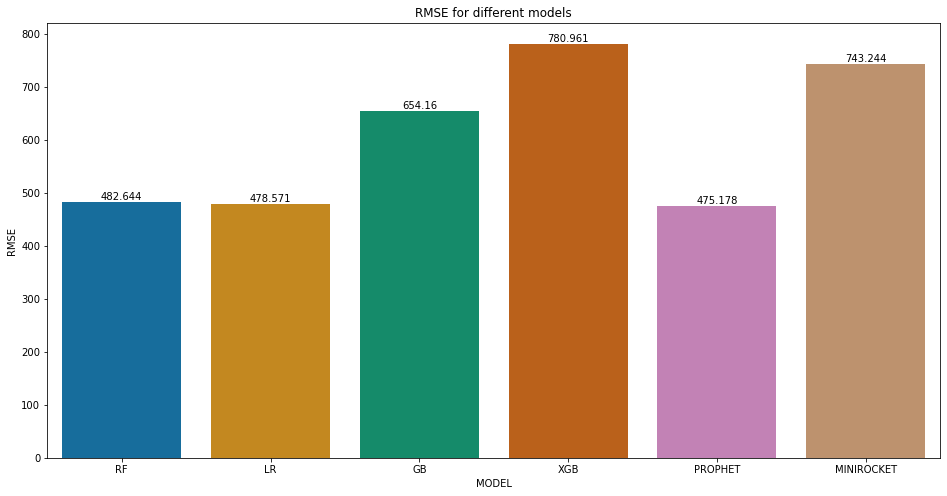

In [1089]:
final_df = predicted_df.copy()
final_metrics = metrics_df.copy()
MODEL_COLUMNS_TO_PLOT = ['Actual close', 'LR close', 'GB close', 'XGB close', 'PROPHET close', 'MINIROCKET close']
plot_predictions(final_df, 'BTC-USD', final_metrics, MODEL_COLUMNS_TO_PLOT)
plot_metric_bar(final_metrics[['Metric', 'RF', 'LR', 'GB', 'XGB', 'PROPHET', 'MINIROCKET']],'RMSE')
display(final_metrics.round(3))
display(final_df)

TESTING NSE STOCKS

In [ ]:
# NOTE: recently the support for nsepy has been removed.
# Code needs to be updated to fetch the daily data from yfinance instead

In [ ]:
# run_models_for_stock('HINDUNILVR')

In [ ]:
# run_models_for_stock('ITC')

In [ ]:
# run_models_for_stock('HDFCBANK')